In [1]:
import pycomod as pcm
import numpy as np

In [15]:
class simple2(pcm.Model):
    def build(self):
        
        P1 = self.pool(20)
        P2 = self.pool(20)
        
        a_v = self.parameter([0.001, 0.005, 0.02])
        a_t = self.parameter([0, 100, 200])
        
        a = self.step(a_v, a_t)
        
        b = self.impulse([2, 4, 6], [10, 20, 30])
        
        F1 = self.flow(lambda: P1*a, src=P1)
        F2 = self.flow(lambda: P2*a, src=P2, discrete=True)
        
        N = self.equation(lambda: P1 + P2)
        
        #F3 = self.flow(lambda: b, src=P1, dest=P2)
        
        self.set_available(locals(), output=('P1', 'P2', 'N'))
        
m2 = simple2()

In [3]:
m2.write_excel_init()

In [16]:
mgr = pcm.RunManager()
mgr.run(m2, duration=400, label='My run')
#mgr.run(m, init="init.xlsx", dt=1, tunit=np.timedelta64(1, 'D'), label='My run')


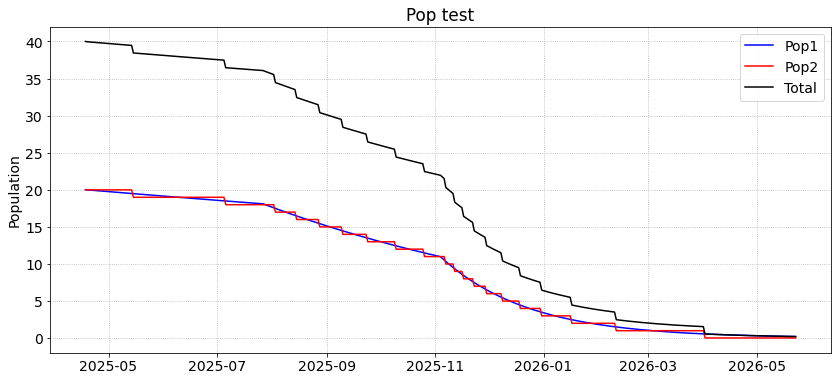

In [18]:
plt = pcm.Plotter(title='Pop test', ylabel='Population', fontsize=14)
plt.plot(mgr['My run'], 'P1', color='blue', label='Pop1')
plt.plot(mgr['My run'], 'P2', color='red', label='Pop2')
plt.plot(mgr['My run'], 'N', color='black', label='Total')

In [6]:
class bigmodel(pcm.Model):
    def build(self):
        m = self.submodel(simple2())
        
        self.set_available(locals(), output=('m',))
        
m3 = bigmodel()

In [7]:
m3.write_excel_init()

In [13]:
mgr = pcm.RunManager()
#mgr.run(m3, duration=400, label='My run')
mgr.run(m3, init="init.xlsx", dt=1, tunit=np.timedelta64(1, 'D'), label='My run')


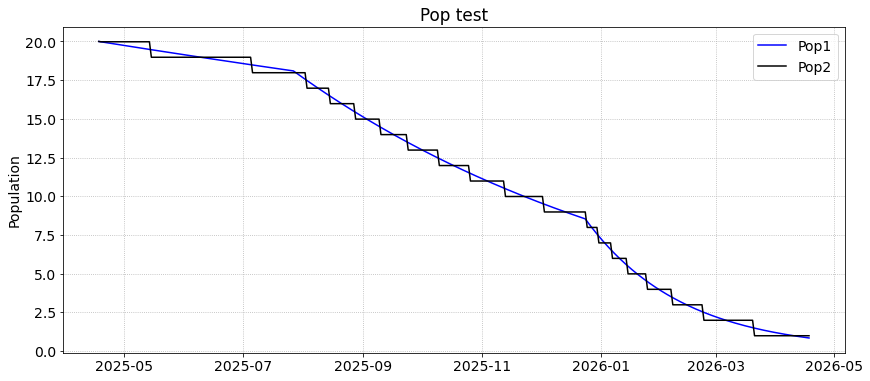

In [14]:
plt = pcm.Plotter(title='Pop test', ylabel='Population', fontsize=14)
plt.plot(mgr['My run'], 'm.P1', color='blue', label='Pop1')
plt.plot(mgr['My run'], 'm.P2', color='black', label='Pop2')